In [58]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
import dask.array as da
from joblib import Parallel, delayed



# Preliminaries

In [59]:


# Number of simulation
n = 920

# Choose between 'local' or 'dahu' or 'dahu_downsized'
where = 'dahu_downsized'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

elif where == 'dahu_downsized':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
    Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))


# Lecture des paramètres :
if where == 'dahu_downsized':
    param = io.read_params(Path_bis)
    nx = 160
    ny = 160
    param['NX'] = nx
    param['NY'] = ny
else:
    param = io.read_params(Path)
    nx = int(param['NX'])
    ny = int(param['NY'])

f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']
print(param)
plt.figure()
plt.imshow(psi[-2, :, :])



la simulation chargée est: dahu_920
depuis: dahu_downsized


FileNotFoundError: [Errno 2] No such file or directory: '/home/massoale/Simu_Test/simu_dahu/simu_dahu920/outdir_downsized/vars.nc'

In [12]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [57]:
#Computing k_rhines to have an idea of the modes to choose

epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)
O = (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L
Z = (beta**2*epsilon/r**5)**(1/20)
print('k_rhines =',k_rhines)    
print("Zono =",Z)
print("Occupation =",O)

n=Lx*(k_rhines)/(2*np.pi)
print("Just look arround n",n)
# print("We want each pixels to be of lengh",np.pi*2/(k_rhines*2))
# print("the new resolution should be",nx/(np.pi*2/(k_rhines*2)))
# print(1024/(960))

freq=-beta*Lx/(2*np.pi*np.sqrt(2))
T_bassfreq=2*np.pi/abs(freq)
print("freq de grave =",freq)  
print("T_bassfreq =",T_bassfreq) 

dtout=T_bassfreq/10 #On veux 10 points par periode

freq_rines=beta*Lx/(2*np.pi*np.sqrt(n))
T_rhines=2*np.pi/abs(freq_rines)
duree=10*T_rhines  #On veux au moins 10 periodes de Rhines
print("freq de rhines =",freq_rines)
print("dtout",dtout)
print("nombre de snapshots minimums =",duree/dtout)


k_rhines = 0.25
Zono = 4.0
Occupation = 0.10000000000007299
Just look arround n 9.999999999992701
freq de grave = -28.284271247441254
T_bassfreq = 0.22214414690808046
freq de rhines = 12.6491106406689
dtout 0.022214414690808044
nombre de snapshots minimums = 223.60679774989737


(748,)


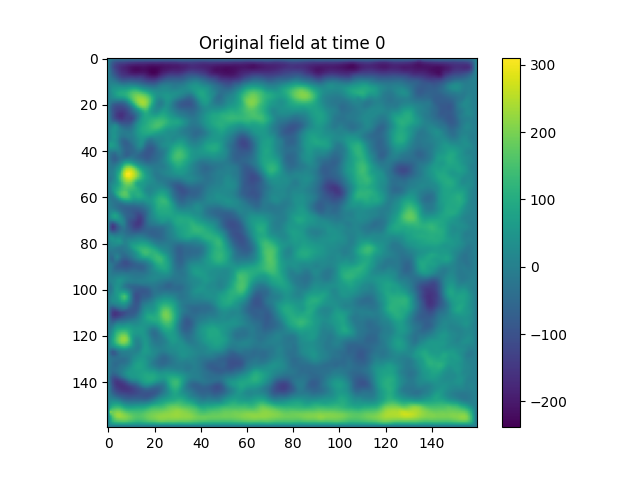

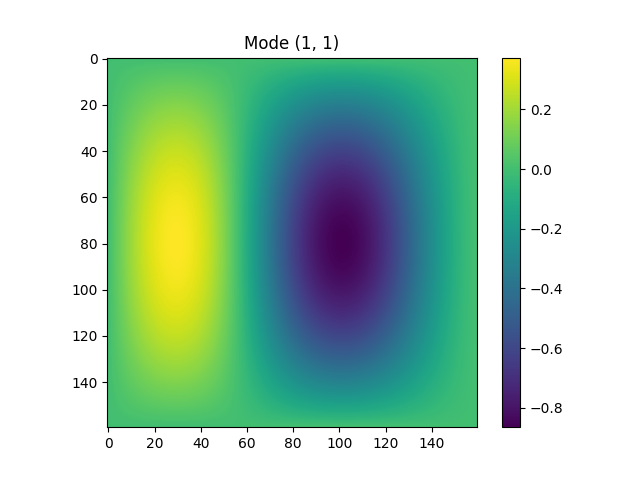

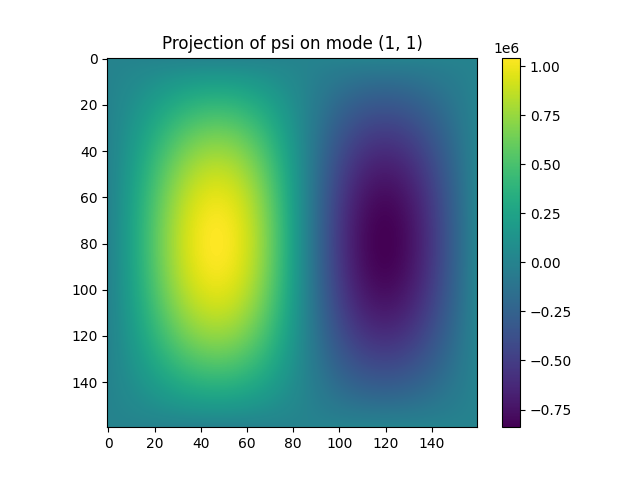

In [45]:
m_sel=1
n_sel=1

time_sel=np.arange(0,len(t),1,dtype=int)
time_plotted=0

psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 1)
print(np.shape(psi_mn))
# Visualize the original field
plt.figure()
plt.imshow(psi[time_plotted, :, :])
plt.colorbar()
plt.title(f'Original field at time {time_plotted}')
plt.show()

# Construct and visualize the mode
N = np.shape(psi[time_plotted, :, :])[-1]
x = np.linspace(0, Lx, N)
y = np.linspace(0, Lx, N)
X, Y = np.meshgrid(x, y)

mode = np.exp(-1j*np.pi*np.sqrt(m_sel**2 + n_sel**2)*X/Lx) * np.sin(m_sel*np.pi*X/Lx) * np.sin(n_sel*np.pi*Y/Lx)

plt.figure()
plt.imshow(np.real(mode))
plt.colorbar()
plt.title(f'Mode ({m_sel}, {n_sel})')
plt.show()

# Reconstruct and visualize the projected field
reconstructed_field = np.real(psi_mn[time_plotted] * mode)

plt.figure()
plt.imshow(reconstructed_field)
plt.colorbar()
plt.title(f'Projection of psi on mode ({m_sel}, {n_sel})')
plt.show()


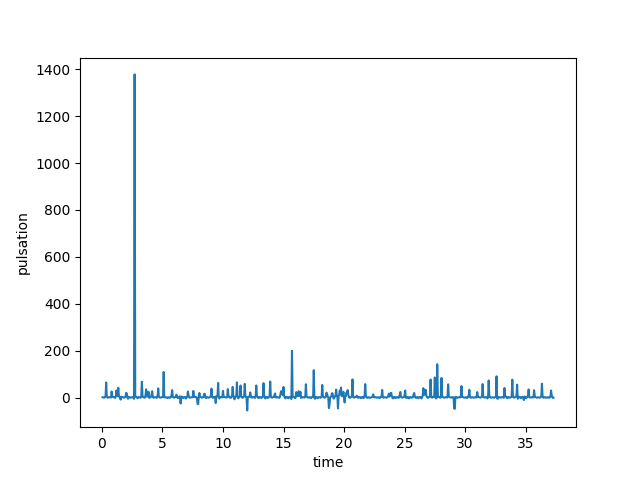

In [46]:
dt=t[1]-t[0]    

# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

plt.figure()
plt.plot(t[1:-1],pulsation_observed)
plt.xlabel('time')
plt.ylabel('pulsation')
plt.show()

In [8]:

def pulsation(psi_mn,t,t_sel):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[t_sel[1]] - t[t_sel[0]]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

# Finding the waves

In [37]:
#Code with parallelization

# Parameters
m_list = np.arange(1, 20, 3) #Modes already checked : 15-30
n_list = np.arange(1, 20, 3) #Modes already checked : 16-22
epsilon1 = 0.3
epsilon2 = 0.3
time_sel=np.arange(0,len(t),1,dtype=int)

pi = np.pi
list_modes = []
list_pulsation = []

def find_mode(m_sel, n_sel,epsilon1,epsilon2):
    """
    Process a single (m, n) mode and return the data for plotting if conditions are met.
    """
    #pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * pi)
    
    #finding the projection of the field on the mode
    psi_mn = project_basin(psi[time_sel, :, :], m_sel, n_sel, Lx, norm=1)
    
    pulsation_observed_brut,pulsation_var = pulsation(psi_mn,t)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    
    #Conditions to discriminates the modes whith wavelike behaviour
    #condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    #condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    
    # if condition1 and condition2:
        
    #     return (real, imag, m_sel, n_sel,np.mean(pulsation_observed_brut, axis=0))
    pulsation_mode_theo=beta*Lx/(np.sqrt(m_sel**2+n_sel**2)*2*np.pi)
    err_relative=np.abs(np.abs(np.mean(pulsation_observed_brut,axis=0)-np.abs(pulsation_mode_theo)))/np.abs(pulsation_mode_theo)

    print("processed mode : ",m_sel,n_sel)
    if err_relative < epsilon1:
        real=np.real(psi_mn)
        imag=np.imag(psi_mn)
        return (real,imag,m_sel,n_sel,np.mean(pulsation_observed_brut,axis=0))
    return None

#results = Parallel(n_jobs=-1)(delayed(find_mode)(m, n) for m in m_list for n in n_list)




In [11]:
#Plotting the relaticve error
#Comparing the 3 different conditions

pi = np.pi


def find_mode_allmethods(m_sel, n_sel, epsilon1, epsilon2, epsilon3, time_sel, q, t):
    """
    Process a single (m, n) mode and return data for plotting if conditions are met.
    """
    # Finding the projection of the field on the mode
    psi_mn = project_basin(q[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
    pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    

    # Conditions to discriminate the modes with wave-like behavior
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    condition3 = rel_err < epsilon3
    
    print("processed mode:", m_sel, n_sel)
    
    results = []
    
    if condition1:
        
        results.append((0, real, imag, m_sel, n_sel,rel_err))
        print("condition 1")
    
    if condition2:
        
        results.append((1, real, imag, m_sel, n_sel,rel_err))
        print("condition 2  ")
         
    if condition3:
        
        results.append((2, real, imag, m_sel, n_sel,rel_err))
        print("condition 3  ")# Conditions to discriminate the modes with wave-like behavior
    
    return results

m_list = np.arange(5, 15, 1) 
n_list = np.arange(5, 15, 1) 
epsilon1 = 0.3
epsilon2 = 0.2
epsilon3 = 0.08

time_sel = np.arange(0, len(t), 1, dtype=int)

# Collect results in parallel
results = Parallel(n_jobs=-1)(delayed(find_mode_allmethods)(m, n, epsilon1, epsilon2, epsilon3, time_sel, psi, t) for m in m_list for n in n_list)

# Flatten the list of results
results_flat = [item for sublist in results for item in sublist]




processed mode: 5 9
processed mode: 5 12
processed mode: 5 5
processed mode: 5 11
processed mode: 5 8
processed mode: 5 10
processed mode: 5 6
processed mode: 5 7
condition 1
condition 1
condition 1
condition 1
condition 2  
condition 3  
condition 2  
condition 3  
condition 3  
condition 2  
condition 3  
condition 2  
condition 3  
condition 2  
condition 3  
condition 2  
condition 3  
processed mode: 5 13
processed mode: 5 14
processed mode: 6 8
processed mode: 6 5
processed mode: 6 6
processed mode: 6 7
processed mode: 6 10
processed mode: 6 9
condition 1
condition 1
condition 1
condition 3  
condition 2  
condition 3  
condition 2  
condition 3  
condition 3  
condition 3  
condition 2  
condition 3  
condition 2  
condition 3  
processed mode: 6 11
processed mode: 6 12
processed mode: 6 13
processed mode: 7 6
processed mode: 7 5
processed mode: 6 14
processed mode: 7 8
processed mode: 7 7
condition 1
condition 1
condition 1
condition 3  
condition 2  
condition 3  
condition 2 

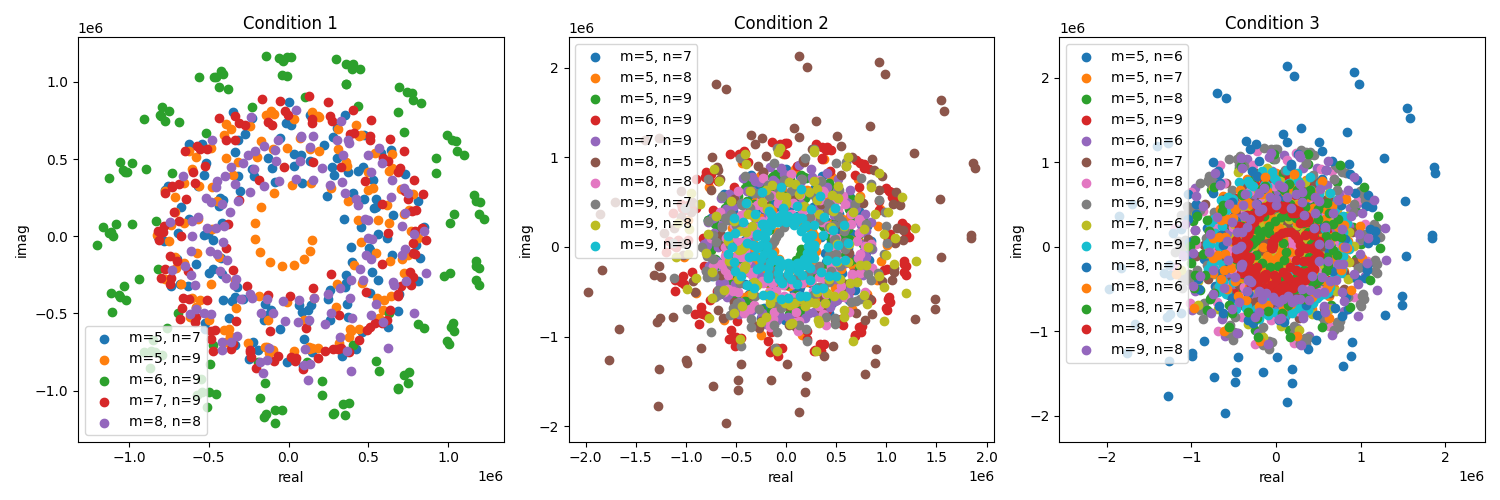

In [10]:

# Create subplots outside the function
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
for result in results_flat:
    ax_idx, real, imag, m_sel, n_sel,rel_err = result
    axes[ax_idx].scatter(real, imag, label=f'm={m_sel}, n={n_sel}')
    axes[ax_idx].set_xlabel('real')
    axes[ax_idx].set_ylabel('imag')

# Add legends and titles to the plots only if data was plotted
for ax, title in zip(axes, ['Condition 1', 'Condition 2', 'Condition 3']):
    if ax.collections:
        ax.legend()
    ax.set_title(title)
plt.axis('equal')
plt.tight_layout()
plt.show() 

In [38]:
#Batch optimisation 
time_sel = np.arange(0, len(t), 1, dtype=int)
pi = np.pi

def finding_parameters(m_sel, n_sel, time_sel,q, t):
    """
    Process a single (m, n) mode and return data for plotting if conditions are met.
    """
    # Finding the projection of the field on the mode
    psi_mn = project_basin(q[time_sel, :, :], m_sel, n_sel, Lx, norm=0)
    
    pulsation_observed_brut, pulsation_var = pulsation(psi_mn, t, time_sel)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * np.pi)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    rel_err = (np.abs(np.abs(np.mean(pulsation_observed_brut, axis=0) - np.abs(pulsation_mode_theo))) / np.abs(pulsation_mode_theo)).compute()
    
    # Conditions to discriminate the modes with wave-like behavior
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) 
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) 
    condition3 = rel_err 

    return condition1, condition2, condition3

m_list = np.arange(0, 20, 1) 
n_list = np.arange(0, 20, 1) 

condition1_tab = np.zeros((len(n_list), len(m_list)))
condition2_tab = np.zeros((len(n_list), len(m_list)))
condition3_tab = np.zeros((len(n_list), len(m_list)))   

# Batch processing
batch_size = 5
m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

for batch_idx, m_batch in enumerate(m_batches):
    print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
    results = Parallel(n_jobs=-1)(delayed(finding_parameters)(m, n, time_sel, q, t) for m in m_batch for n in n_list)
    
    for idx, (m, n) in enumerate([(m, n) for m in m_batch for n in n_list]):
        m_idx = np.where(m_list == m)[0][0]
        n_idx = np.where(n_list == n)[0][0]
        condition1_tab[n_idx, m_idx], condition2_tab[n_idx, m_idx], condition3_tab[n_idx, m_idx] = results[idx]


Processing batch 1/4


/tmp/ipykernel_879691/1577268223.py:15: RuntimeWarning: divide by zero encountered in scalar divide
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/

/home/massoale/.local/lib/python3.10/site-packages/dask/array/core.py:4919: RuntimeWarning: invalid value encountered in scalar divide
  result = function(*args, **kwargs)


Processing batch 2/4


/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Processing batch 3/4


/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Processing batch 4/4


/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/massoale/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


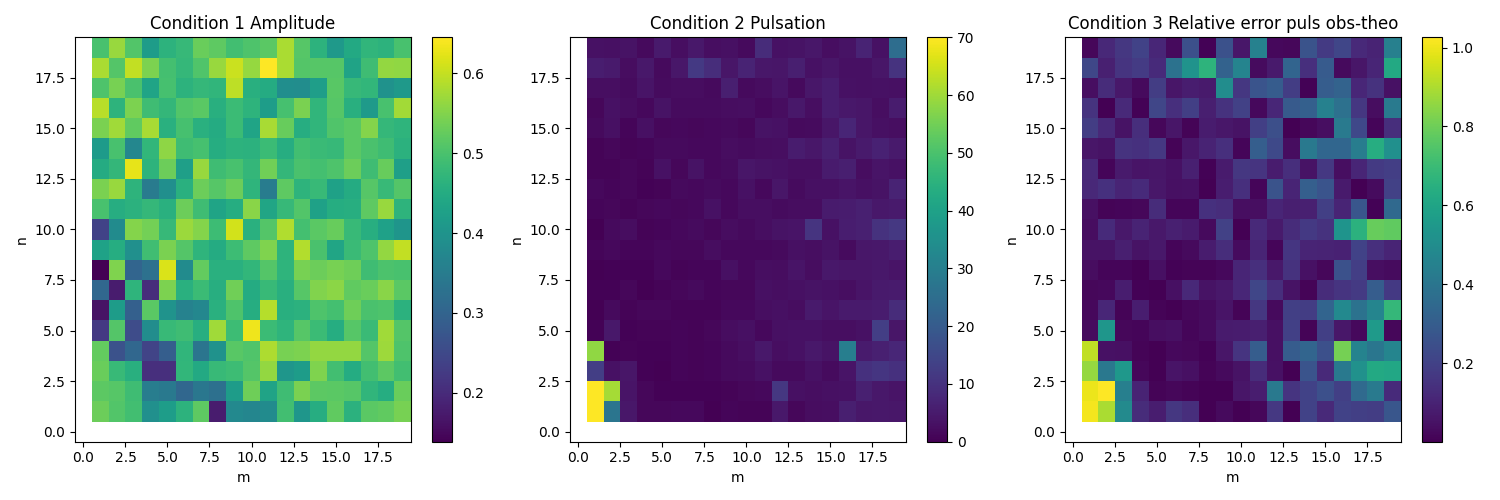

In [39]:

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting condition1
c1 = axs[0].pcolormesh(n_list,m_list,condition1_tab)
axs[0].set_title('Condition 1 Amplitude')
axs[0].set_xlabel('m')
axs[0].set_ylabel('n')
fig.colorbar(c1, ax=axs[0], orientation='vertical')

# Plotting condition2
c2 = axs[1].pcolormesh(n_list,m_list,condition2_tab,vmin=0,vmax=70)
axs[1].set_title('Condition 2 Pulsation')
axs[1].set_xlabel('m')
axs[1].set_ylabel('n')
fig.colorbar(c2, ax=axs[1], orientation='vertical')

# Plotting condition3
c3 = axs[2].pcolormesh(n_list,m_list,condition3_tab)#,vmin=0,vmax=1.3)
axs[2].set_title('Condition 3 Relative error puls obs-theo')
axs[2].set_xlabel('m')
axs[2].set_ylabel('n')

fig.colorbar(c3, ax=axs[2], orientation='vertical')


plt.tight_layout()
plt.savefig("../figures/Wave_sign_closed_case/3conditions_compared_mode_" + str(m_list[0]) + "-" + str(m_list[-1]) + "simu"+where+str(simu_name)+ ".png")
plt.show()

# Energy contained in the modes

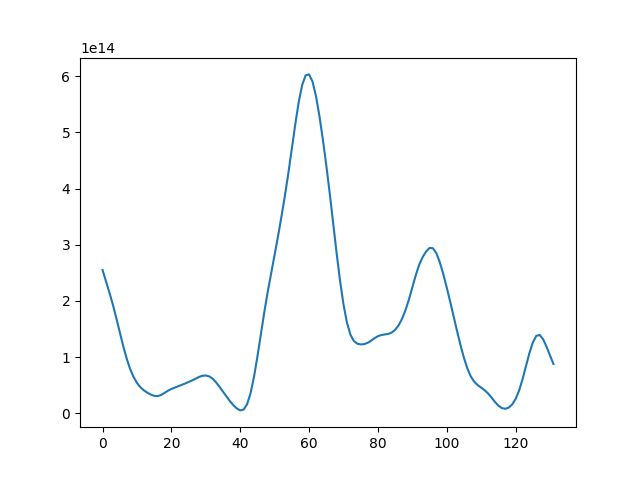

In [8]:
m=15
n=17
pi=np.pi
E_mn =pi*2*(m**2+n**2)/4*np.abs(psi_mn)**2/Lx**2
plt.figure()
plt.plot(E_mn)
plt.show()

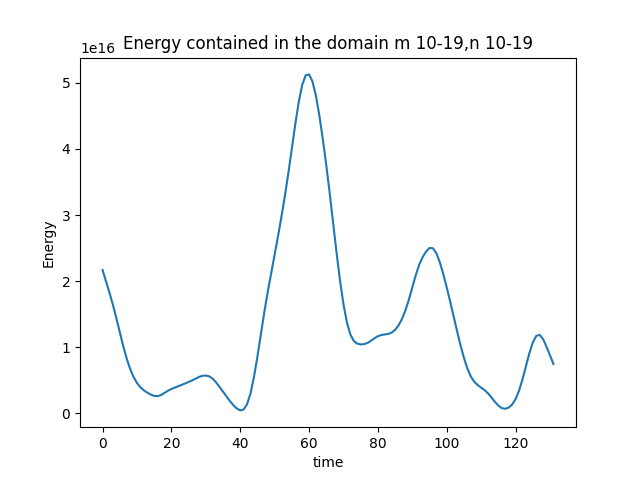

In [9]:

#Energy contained in a specific region
m_list=np.arange(10,20,1)
n_list=np.arange(10,20,1)

E_domain=0
for m in m_list:
    for n in n_list:
        E_domain += pi*2*(m**2+n**2)/4*np.abs(psi_mn)**2/Lx**2
        #print("Energy contained in mode",m,n,"is",np.sum(E_mn))

plt.figure()
plt.plot(E_domain)
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Energy contained in the domain m '+str(m_list[0])+'-'+str(m_list[-1])+',n '+str(n_list[0])+'-'+str(n_list[-1]))
plt.savefig('Energy_domain'+str(m_list[0])+'-'+str(m_list[-1])+','+str(n_list[0])+'-'+str(n_list[-1])+'.png')
plt.show()


In [60]:

#Computing energy with batch

m_list = np.arange(1, 40, 1)
n_list = np.arange(1, 40, 1)
time_sel = np.arange(0, len(t), 3, dtype=int)

# Function to compute energy for given m and n
def compute_energy(m, n):
    psi_mn = project_basin(q[time_sel], m, n, Lx, 0)  # Replace project_basin with your actual function
    energy = np.abs(psi_mn)**2 / Lx**2
    return energy

# Function to handle batch processing
def process_batch(m_batch, n_list):
    batch_results = []
    for m in m_batch:
        results = Parallel(n_jobs=4)(delayed(compute_energy)(m, n) for n in n_list)
        batch_results.append(results)
    return batch_results

# Number of modes in each batch
batch_size = 5
m_batches = [m_list[i:i + batch_size] for i in range(0, len(m_list), batch_size)]

E_plot = np.zeros((len(time_sel), len(m_list), len(n_list)))

for batch_idx, m_batch in enumerate(m_batches):
    print(f"Processing batch {batch_idx + 1}/{len(m_batches)}")
    batch_results = process_batch(m_batch, n_list)
    
    for batch_i, m_results in enumerate(batch_results):
        m_index = batch_idx * batch_size + batch_i
        for n_index, energy in enumerate(m_results):
            E_plot[:, m_index, n_index] = energy



Processing batch 1/8


Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8


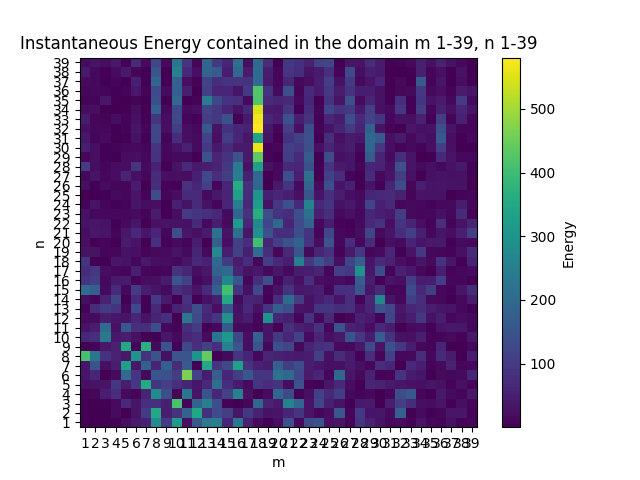

In [61]:
np.save('../saving/E_plot.npy',E_plot)
# Plotting
plt.figure()
plt.pcolormesh(m_list,n_list,E_plot[0, :, :])
plt.xlabel('m')
plt.ylabel('n')
plt.title(f'Instantaneous Energy contained in the domain m {m_list[0]}-{m_list[-1]}, n {n_list[0]}-{n_list[-1]}')

# Set the ticks
plt.xticks(ticks=np.arange(m_list[0], m_list[-1]+1, step=1))
plt.yticks(ticks=np.arange(n_list[0], n_list[-1]+1, step=1))

plt.colorbar(label='Energy')
plt.savefig(f'../figures/Energy_closed_domain/Energy_domain_{m_list[0]}-{m_list[-1]}_{n_list[0]}-{n_list[-1]}_simu'+str(simu_name)+'.png')
plt.show()

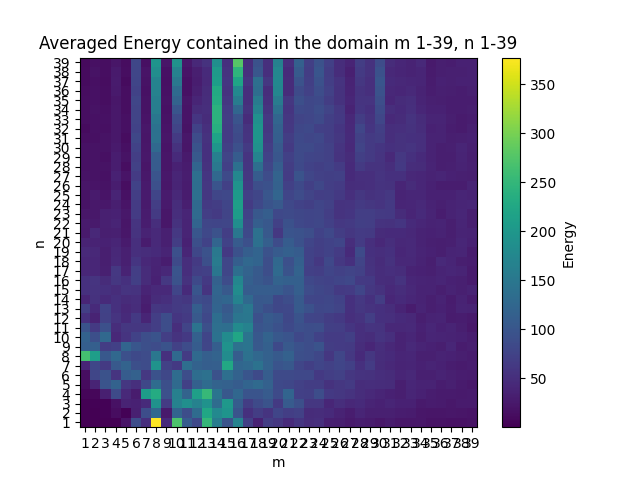

In [62]:

# Plotting
plt.figure()
plt.pcolormesh(m_list,n_list,np.mean(E_plot[:, :, :],axis=0))
plt.xlabel('m')
plt.ylabel('n')
plt.title('Averaged Energy contained in the domain m {}-{}, n {}-{}'.format(m_list[0], m_list[-1], n_list[0], n_list[-1]))

# Set the ticks
plt.xticks(ticks=np.arange(m_list[0], m_list[-1]+1, step=1))
plt.yticks(ticks=np.arange(n_list[0], n_list[-1]+1, step=1))

plt.colorbar(label='Energy')
plt.savefig('../figures/Energy_closed_domain/Energy_domain_averaged{}-{}_{}-{}_simu'.format(m_list[0], m_list[-1], n_list[0], n_list[-1])+simu_name+'.png')
plt.show()

In [ ]:
#Method 2 : Trying the criterion of comparing with the theorethical pulsation:


def find_mode_puls(psi,m_sel,n_sel,epsilon):
    """Compare the observed pulsation with the theorethical one and return the modes if the relative error is less than epsilon."""
    
    pulsation_mode_theo=beta*Lx/(np.sqrt(m_sel**2+n_sel**2)*2*np.pi)
    
    psi_mn=project_basin(psi[time_sel,:,:],m_sel,n_sel,Lx,norm=1)
    
    pulsation_observed_brut,_=pulsation(psi_mn,t)

    err_relative=np.abs(np.abs(np.mean(pulsation_observed_brut,axis=0)-np.abs(pulsation_mode_theo)))/np.abs(pulsation_mode_theo)
    print("processed mode : ",m_sel,n_sel)
    if err_relative < epsilon:
        real=np.real(psi_mn)
        imag=np.imag(psi_mn)
        return (real,imag,m_sel,n_sel,np.mean(pulsation_observed_brut,axis=0))
    else:
        return None
    


In [ ]:
# Saving the pulsation and the modes in an array
filtered_results = [result for result in results if result is not None]


pulsation_array = np.zeros(len(filtered_results))
mn_wave_array = np.zeros((len(filtered_results),2))



for index,result in enumerate(filtered_results):
    
    real, imag, m_sel, n_sel,pulsation = result
    pulsation_array[index]=pulsation
    mn_wave_array[index,0]=m_sel
    mn_wave_array[index,1]=n_sel

#Concataining all the results
#first_part_modes=np.load("./Saving_modes/modes_method2{}.npy".format(epsilon))
#first_part_pulsation=np.load("./Saving_modes/pulsation_method2{}.npy".format(epsilon))  

#mn_wave_array=np.concatenate((first_part_modes,mn_wave_array),axis=0)
#pulsation_array=np.concatenate((first_part_pulsation,pulsation_array),axis=0)

#Saving the modes in a file
np.save("./Saving_modes/modes_method2{}.npy".format(epsilon),mn_wave_array)
np.save("./Saving_modes/pulsation_method2{}.npy".format(epsilon),pulsation_array)

#saving the modes in a file
#np.save("./Saving_modes/modes_method2{}.npy".format(epsilon),mn_wave_array)
#np.save("./Saving_modes/pulsation_method2{}.npy".format(epsilon),pulsation_array)

NameError: name 'filtered_results' is not defined

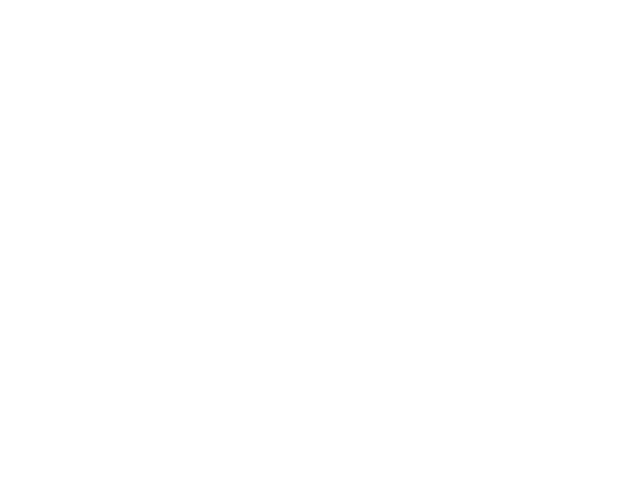

In [ ]:
# Plotting 


plt.figure()
for index,result in enumerate(filtered_results):
    
    real, imag, m_sel, n_sel,pulsation = result
    
    plt.scatter(real, imag, label=f'm={m_sel}, n={n_sel}')
    plt.legend()

plt.xlabel('real')
plt.ylabel('imag')
plt.title('Modes amplitude on the complex plane')
plt.axis('equal')   
plt.savefig("../figures/Wave_sign_closed_case/mode_vibration_{}_{}.png".format(epsilon1, epsilon2))
plt.show()

In [ ]:
print(len(mn_wave_array))

226


The modes behaving like waves seems to be between 15 and 21

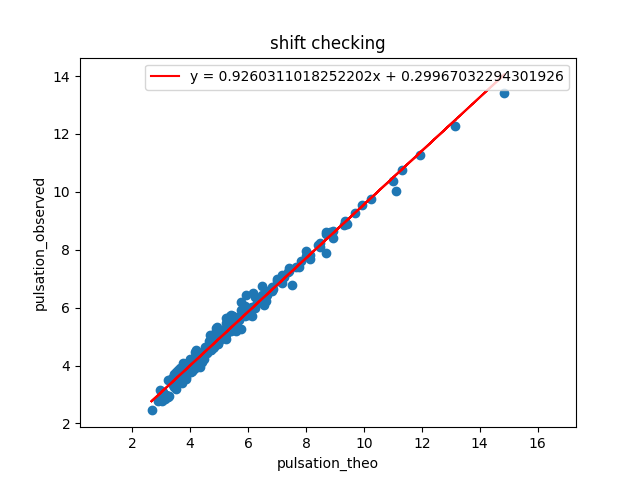

In [ ]:
#Checking if the modes are doppler shifted

pulsation_theo=beta*Lx/(np.sqrt(mn_wave_array[:,0]**2+mn_wave_array[:,1]**2)*2*np.pi)
#interpoling the line
pol = np.polyfit(pulsation_theo,pulsation_array,1)


plt.figure()
plt.scatter(pulsation_theo,pulsation_array)
plt.plot(pulsation_theo,np.polyval(pol,pulsation_theo),label='y = {}x + {}'.format(pol[0],pol[1]),color='red')
plt.xlabel('pulsation_theo')
plt.ylabel('pulsation_observed')
plt.title('shift checking')
plt.axis('equal')
plt.legend()
plt.savefig("../figures/Wave_sign_closed_case/doppler_shift_{}_{}.png".format(epsilon1, epsilon2))
plt.show()

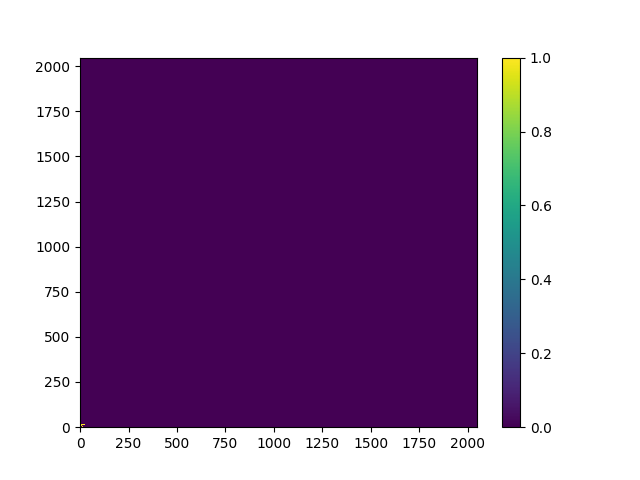

In [ ]:
#Plotting the binary maps of the wavelike modes

binary_map = np.zeros((nx,ny))
Mx=np.arange(0,nx,1)
Ny=np.arange(0,ny,1)
X,Y=np.meshgrid(Mx,Ny)

plt.figure()

for i in range(0,len(mn_wave_array)):
    
    binary_map[int(mn_wave_array[i,1]), int(mn_wave_array[i,0])] = 1

plt.pcolormesh(X,Y,binary_map) 
plt.colorbar()

plt.show()